In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *
from src.utils import *
from src.networks import *

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(7)
limit_mem()

In [4]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [6]:
args = load_args('../nn_configs/B/81-resnet_d3_dr_0.1.yml')
args['exp_id'] = '81.1-resnet_d3_dr_0.1'

In [41]:
args['train_years'] = ['2015', '2015']
dg_train, dg_valid, dg_test = load_data(**args)

In [42]:
args['filters'] = [128, 128, 128, 128, 128, 128, 128, 128, 
                   128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 4]

In [43]:
model = build_resnet(
    **args, input_shape=dg_train.shape,
)

In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 114) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  715136      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [45]:
X, y = dg_train[0]

In [46]:
model.output

<tf.Tensor 'activation/Identity:0' shape=(None, 32, 64, 4) dtype=float32>

In [47]:
y.shape

(32, 32, 64, 2)

## Combined CRPS MAE

In [48]:
crps_mae = create_lat_crps_mae(dg_train.data.lat, 2)

In [49]:
preds = model(X)

In [50]:
crps_mae(y, preds)

<tf.Tensor: shape=(), dtype=float32, numpy=69.451355>

## Log

In [30]:
def pdf(y, mu, sigma):
    eps = 1e-7
    sigma = np.maximum(eps, sigma)
    p = 1 / sigma / np.sqrt(2*np.pi) * np.exp(
        -0.5 * ((y - mu) / sigma)**2
    )
    return p

In [12]:
from scipy.stats import norm

In [16]:
pdf(5, 0.1, 3), norm.pdf(3, loc=5, scale=0.1)

(5.520948362159764e-87, 5.5209483621597635e-87)

In [26]:
def log_loss(y_true, mu, sigma):
    
    prob = pdf(y_true, mu, sigma)
    ll = - np.log(prob)
    return ll

In [35]:
mu = 3
sigma = 5
y = 3
log_loss(y, mu, sigma)

2.5283764456387727

In [73]:
def create_lat_log_loss(lat, n_vars):
    weights_lat = np.cos(np.deg2rad(lat)).values
    weights_lat /= weights_lat.mean()
    def log_loss(y_true, y_pred):
        # Split input
        mu = y_pred[:, :, :, :n_vars]
        sigma = y_pred[:, :, :, n_vars:]
        sigma = tf.nn.relu(sigma)
        
        # Compute PDF
        eps = 1e-7
        sigma = tf.maximum(eps, sigma)
        prob = 1 / sigma / np.sqrt(2*np.pi) * tf.math.exp(
            -0.5 * ((y_true - mu) / sigma)**2
        )
        
        # Compute log loss
        ll = - tf.math.log(tf.maximum(prob, eps))
        ll = ll * weights_lat[None, : , None, None]
        
        return tf.reduce_mean(ll)
    return log_loss

In [74]:
ll = create_lat_log_loss(dg_train.data.lat, 2)

In [75]:
ll(y, preds)

<tf.Tensor: shape=(), dtype=float32, numpy=10.518727>

## CRPS

In [14]:
type(y)

numpy.ndarray

In [15]:
pred = model(X)

In [16]:
type(pred)

tensorflow.python.framework.ops.EagerTensor

In [19]:
type(tf.math.sqrt(pred))

tensorflow.python.framework.ops.EagerTensor

In [22]:
y.shape[-1]

2

In [23]:
y_true, y_pred = y, pred

In [24]:
n_vars = y_true.shape[-1]

In [25]:
mu = y_pred[:, :, :, :n_vars]
sigma = y_pred[:, :, :, n_vars:]

In [26]:
mu.shape, sigma.shape

(TensorShape([32, 32, 64, 2]), TensorShape([32, 32, 64, 2]))

In [29]:
np.min(sigma)

-301.75

In [31]:
sigma = tf.math.sqrt(tf.math.square(sigma))

In [32]:
np.min(sigma)

0.0023956299

In [33]:
loc = (y_true - mu) / sigma

In [34]:
loc.shape

TensorShape([32, 32, 64, 2])

In [36]:
phi = 1.0 / np.sqrt(2.0 * np.pi) * tf.math.exp(-tf.math.square(loc) / 2.0)

In [38]:
phi.shape

TensorShape([32, 32, 64, 2])

In [39]:
Phi = 0.5 * (1.0 + tf.math.erf(loc / np.sqrt(2.0)))

In [40]:
crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))

In [41]:
crps.shape

TensorShape([32, 32, 64, 2])

In [42]:
tf.reduce_mean(crps)

<tf.Tensor: shape=(), dtype=float32, numpy=31.902512>

In [43]:
def crps_cost_function(y_true, y_pred):
    
    n_vars = y_true.shape[-1]
    
    # Split input
    mu = y_pred[:, :, :, :n_vars]
    sigma = y_pred[:, :, :, n_vars:]

    # To stop sigma from becoming negative we first have to 
    # convert it the the variance and then take the square
    # root again. 
    sigma = tf.math.sqrt(tf.math.square(sigma))
    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / np.sqrt(2.0 * np.pi) * tf.math.exp(-tf.math.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / np.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps)

In [233]:
y_test = np.zeros((32, 32, 64, 2))
pred_test = np.concatenate([-np.ones_like(y_test), np.zeros_like(y_test)], axis=-1)

In [234]:
pred_test = tf.Variable(pred_test)

In [235]:
y_test.shape, pred_test.shape

((32, 32, 64, 2), TensorShape([32, 32, 64, 4]))

In [236]:
crps_cost_function(y_test, pred_test)

<tf.Tensor: shape=(), dtype=float64, numpy=nan>

In [74]:
dg_train.data.lat

<xarray.DataArray 'lat' (lat: 32)>
array([-87.1875, -81.5625, -75.9375, -70.3125, -64.6875, -59.0625, -53.4375,
       -47.8125, -42.1875, -36.5625, -30.9375, -25.3125, -19.6875, -14.0625,
        -8.4375,  -2.8125,   2.8125,   8.4375,  14.0625,  19.6875,  25.3125,
        30.9375,  36.5625,  42.1875,  47.8125,  53.4375,  59.0625,  64.6875,
        70.3125,  75.9375,  81.5625,  87.1875])
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19

In [238]:
import pdb
def create_lat_crps(lat, n_vars):
    weights_lat = np.cos(np.deg2rad(lat)).values
    weights_lat /= weights_lat.mean()
    def crps_loss(y_true, y_pred):
#         pdb.set_trace()
        # Split input
        mu = y_pred[:, :, :, :n_vars]
        sigma = y_pred[:, :, :, n_vars:]

        # To stop sigma from becoming negative we first have to 
        # convert it the the variance and then take the square
        # root again. 
        sigma = tf.math.sqrt(tf.math.square(sigma))

        # The following three variables are just for convenience
        loc = (y_true - mu) / tf.maximum(1e-7, sigma)
        phi = 1.0 / np.sqrt(2.0 * np.pi) * tf.math.exp(-tf.math.square(loc) / 2.0)
        Phi = 0.5 * (1.0 + tf.math.erf(loc / np.sqrt(2.0)))
        # First we will compute the crps for each input/target pair
        crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))
        crps = crps * weights_lat[None, : , None, None]

        # Then we take the mean. The cost is now a scalar
        return tf.reduce_mean(crps)
    return crps_loss

In [246]:
dg_train.output_idxs

[2, 12]

In [239]:
crps_test = create_lat_crps(dg_train.data.lat, 2)

In [240]:
crps_test(y_test, pred_test)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

In [247]:
model = build_resnet(
    **args, input_shape=dg_train.shape,
)

In [248]:
model.compile(keras.optimizers.Adam(1e-3), crps_test)

In [249]:
from src.clr import LRFinder

In [254]:
lrf = LRFinder(
    dg_train.n_samples, args['batch_size'],
    minimum_lr=1e-5, maximum_lr=10,
    lr_scale='exp', save_dir='./', verbose=0)

In [255]:
model.fit(dg_train, epochs=1,
         callbacks=[lrf], shuffle=False)

  ...
    to  
  ['...']
Train for 273 steps
273/273 [==============================] - 46s 170ms/step - loss: 2.0711


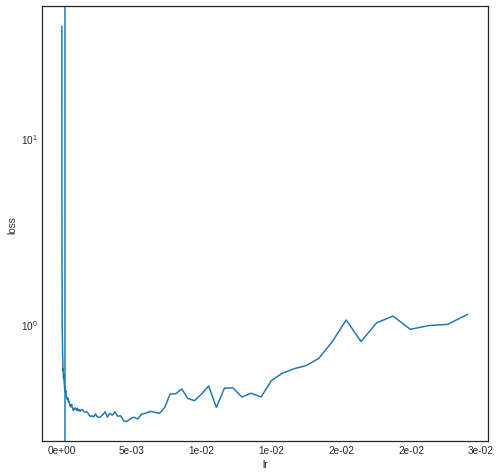

In [260]:
plot_lr_find(lrf, log=True)
plt.axvline(2.5e-4)

In [212]:
X, y = dg_train[31]
crps_test(y, model(X))

> <ipython-input-209-5509bd447abb>(8)crps_loss()
-> mu = y_pred[:, :, :, :n_vars]


(Pdb)  l


  3  	    weights_lat = np.cos(np.deg2rad(lat)).values
  4  	    weights_lat /= weights_lat.mean()
  5  	    def crps_loss(y_true, y_pred):
  6  	        pdb.set_trace()
  7  	        # Split input
  8  ->	        mu = y_pred[:, :, :, :n_vars]
  9  	        sigma = y_pred[:, :, :, n_vars:]
 10  	
 11  	        # To stop sigma from becoming negative we first have to
 12  	        # convert it the the variance and then take the square
 13  	        # root again.


(Pdb)  n


> <ipython-input-209-5509bd447abb>(9)crps_loss()
-> sigma = y_pred[:, :, :, n_vars:]


(Pdb)  n


> <ipython-input-209-5509bd447abb>(14)crps_loss()
-> sigma = tf.math.sqrt(tf.math.square(sigma))


(Pdb)  mu


<tf.Tensor: shape=(32, 32, 64, 2), dtype=float32, numpy=
array([[[[-9.46875000e+00,  1.07437500e+02],
         [-6.07421875e+00,  1.04312500e+02],
         [-2.79296875e+00,  1.01187500e+02],
         ...,
         [-2.19687500e+01,  1.13625000e+02],
         [-1.77187500e+01,  1.12437500e+02],
         [-1.31484375e+01,  1.10687500e+02]],

        [[ 2.83000000e+02, -4.21250000e+01],
         [ 2.79750000e+02, -4.15000000e+01],
         [ 2.74750000e+02, -3.90312500e+01],
         ...,
         [ 2.42000000e+02, -2.80781250e+01],
         [ 2.62750000e+02, -3.60625000e+01],
         [ 2.77500000e+02, -4.06875000e+01]],

        [[ 4.53500000e+02, -6.26875000e+01],
         [ 4.46000000e+02, -6.13750000e+01],
         [ 4.37000000e+02, -5.89062500e+01],
         ...,
         [ 4.33750000e+02, -4.12812500e+01],
         [ 4.51500000e+02, -5.34687500e+01],
         [ 4.56250000e+02, -6.13437500e+01]],

        ...,

        [[ 5.22500000e+02,  1.79250000e+02],
         [ 5.61500000e+02,

(Pdb)  l


  9  	        sigma = y_pred[:, :, :, n_vars:]
 10  	
 11  	        # To stop sigma from becoming negative we first have to
 12  	        # convert it the the variance and then take the square
 13  	        # root again.
 14  ->	        sigma = tf.math.sqrt(tf.math.square(sigma))
 15  	        tf.debugging.check_numerics(
 16  	            sigma, 'sigma'
 17  	        )
 18  	        # The following three variables are just for convenience
 19  	        loc = (y_true - mu) / sigma


(Pdb)  np.max(mu)


1358.0


(Pdb)  np.min(mu)


-165.75


(Pdb)  n


> <ipython-input-209-5509bd447abb>(15)crps_loss()
-> tf.debugging.check_numerics(


(Pdb)  n


> <ipython-input-209-5509bd447abb>(16)crps_loss()
-> sigma, 'sigma'


(Pdb)  n


> <ipython-input-209-5509bd447abb>(19)crps_loss()
-> loc = (y_true - mu) / sigma


(Pdb)  n


> <ipython-input-209-5509bd447abb>(20)crps_loss()
-> phi = 1.0 / np.sqrt(2.0 * np.pi) * tf.math.exp(-tf.math.square(loc) / 2.0)


(Pdb)  n


> <ipython-input-209-5509bd447abb>(21)crps_loss()
-> Phi = 0.5 * (1.0 + tf.math.erf(loc / np.sqrt(2.0)))


(Pdb)  n


> <ipython-input-209-5509bd447abb>(23)crps_loss()
-> crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))


(Pdb)  n


> <ipython-input-209-5509bd447abb>(24)crps_loss()
-> crps = crps * weights_lat[None, : , None, None]


(Pdb)  n


> <ipython-input-209-5509bd447abb>(25)crps_loss()
-> tf.debugging.check_numerics(


(Pdb)  n


> <ipython-input-209-5509bd447abb>(26)crps_loss()
-> crps, 'crps'


(Pdb)  n


> <ipython-input-209-5509bd447abb>(29)crps_loss()
-> return tf.reduce_mean(crps)


(Pdb)  np.max(crps)


777.77997


(Pdb)  crps.shape


TensorShape([32, 32, 64, 2])


(Pdb)  q


BdbQuit: 

In [208]:
for i, (X, y) in enumerate(dg_train):
    loss = crps_test(y, model(X))
    print(loss)

tf.Tensor(189.4203, shape=(), dtype=float32)
tf.Tensor(189.25871, shape=(), dtype=float32)
tf.Tensor(189.9216, shape=(), dtype=float32)
tf.Tensor(194.10907, shape=(), dtype=float32)
tf.Tensor(194.72154, shape=(), dtype=float32)
tf.Tensor(192.99498, shape=(), dtype=float32)
tf.Tensor(190.03615, shape=(), dtype=float32)
tf.Tensor(191.85597, shape=(), dtype=float32)
tf.Tensor(189.76843, shape=(), dtype=float32)
tf.Tensor(195.57434, shape=(), dtype=float32)
tf.Tensor(198.33441, shape=(), dtype=float32)
tf.Tensor(195.01407, shape=(), dtype=float32)
tf.Tensor(193.54872, shape=(), dtype=float32)
tf.Tensor(195.62596, shape=(), dtype=float32)
tf.Tensor(195.55945, shape=(), dtype=float32)
tf.Tensor(189.2996, shape=(), dtype=float32)
tf.Tensor(189.54698, shape=(), dtype=float32)
tf.Tensor(193.51878, shape=(), dtype=float32)
tf.Tensor(196.58882, shape=(), dtype=float32)
tf.Tensor(197.74637, shape=(), dtype=float32)
tf.Tensor(195.90904, shape=(), dtype=float32)
tf.Tensor(192.02011, shape=(), dtype=

KeyboardInterrupt: 

In [284]:
dg_valid.data

<xarray.DataArray 'z' (time: 4392, lat: 32, lon: 64, level: 38)>
array([[[[ 6.51738590e-02, -1.45386492e+00, -1.74141261e+00, ...,
           1.44426201e+00,  2.57085561e+00, -1.67874412e+00],
         [ 6.17519356e-02, -1.45322996e+00, -1.74469150e+00, ...,
           1.44426201e+00,  2.63684811e+00, -1.67874412e+00],
         [ 5.83300122e-02, -1.45195701e+00, -1.74687786e+00, ...,
           1.44426201e+00,  2.70122081e+00, -1.67874412e+00],
         ...,
         [ 8.02381510e-02, -1.45195701e+00, -1.71954772e+00, ...,
           1.44426201e+00,  2.40688572e+00, -1.67874412e+00],
         [ 7.47611163e-02, -1.45322996e+00, -1.72720063e+00, ...,
           1.44426201e+00,  2.47378905e+00, -1.67874412e+00],
         [ 6.92840816e-02, -1.45386492e+00, -1.73485353e+00, ...,
           1.44426201e+00,  2.52247395e+00, -1.67874412e+00]],

        [[ 1.45104725e-02, -1.35208502e+00, -1.59601260e+00, ...,
           1.44426201e+00,  2.06275586e+00, -1.57043805e+00],
         [ 8.19516724e-04, -1.33109347e+00, -1.55993573e+00, ...,
           1.44426201e+00,  2.33441714e+00, -1.57043805e+00],
         [-1.15046269e-02, -1.30755602e+00, -1.51729979e+00, ...,
           1.44426201e+00,  2.47945850e+00, -1.57043805e+00],
         ...,
         [ 6.44888219e-02, -1.37562246e+00, -1.63536836e+00, ...,
           1.44426201e+00,  1.50808802e+00, -1.57043805e+00],
         [ 4.53208315e-02, -1.37371304e+00, -1.63755602e+00, ...,
           1.44426201e+00,  1.76416741e+00, -1.57043805e+00],
         [ 2.88864653e-02, -1.36544341e+00, -1.62225021e+00, ...,
           1.44426201e+00,  1.87833927e+00, -1.57043805e+00]],

        [[-6.28563126e-02, -1.13961910e+00, -1.30630642e+00, ...,
           1.44426201e+00,  2.80071523e+00, -1.46213197e+00],
         [-8.27093402e-02, -1.09127429e+00, -1.25929776e+00, ...,
           1.44426201e+00,  3.12389527e+00, -1.46213197e+00],
         [-9.77736322e-02, -1.04928968e+00, -1.21666181e+00, ...,
           1.44426201e+00,  3.37895707e+00, -1.46213197e+00],
         ...,
         [ 4.66909057e-02, -1.21595517e+00, -1.44296099e+00, ...,
           1.44426201e+00,  8.59694584e-01, -1.46213197e+00],
         [ 4.23817805e-03, -1.21404575e+00, -1.40579159e+00, ...,
           1.44426201e+00,  2.03308297e+00, -1.46213197e+00],
         [-3.13641786e-02, -1.18414961e+00, -1.36206312e+00, ...,
           1.44426201e+00,  2.49159806e+00, -1.46213197e+00]],

        ...,

        [[-2.48998190e+00, -8.98528492e-01, -8.44963924e-01, ...,
          -7.34369322e-01, -4.41508818e-01,  1.46213197e+00],
         [-2.31881396e+00, -6.77156477e-01, -6.62394519e-01, ...,
          -7.34369322e-01, -4.40901513e-01,  1.46213197e+00],
         [-2.18393668e+00, -4.72323716e-01, -4.90756906e-01, ...,
          -7.34369322e-01, -4.41913690e-01,  1.46213197e+00],
         ...,
         [-2.87613079e+00, -1.43033202e+00, -1.29319217e+00, ...,
          -7.34369299e-01, -4.35841996e-01,  1.46213197e+00],
         [-2.76521676e+00, -1.29165779e+00, -1.13795290e+00, ...,
          -7.34369322e-01, -4.41205164e-01,  1.46213197e+00],
         [-2.64334866e+00, -1.10272932e+00, -9.96925611e-01, ...,
          -7.34369322e-01, -4.41103999e-01,  1.46213197e+00]],

        [[-2.62965118e+00, -1.24394339e+00, -1.25273868e+00, ...,
          -7.34369322e-01, -4.41306382e-01,  1.57043805e+00],
         [-2.56529357e+00, -1.15043311e+00, -1.17511970e+00, ...,
          -7.34369322e-01, -4.40699074e-01,  1.57043805e+00],
         [-2.48655671e+00, -1.03847567e+00, -1.09531305e+00, ...,
          -7.34369322e-01, -4.42419778e-01,  1.57043805e+00],
         ...,
         [-2.83573643e+00, -1.43541776e+00, -1.44077463e+00, ...,
           1.06439006e+00, -2.83015586e-01,  1.57043805e+00],
         [-2.77206060e+00, -1.39089028e+00, -1.39267344e+00, ...,
          -2.99333107e-01, -3.98481756e-01,  1.57043805e+00],
         [-2.70359930e+00, -1.32600622e+00, -1.32707878e+00, ...,
          -7.34369322e-01, -4.43735187e-01,  1.57043805e+00]],

 

In [306]:
np.concatenate([dg.std.isel(level=dg.output_idxs).values]*2)

array([2999.77955214,   14.37059166, 2999.77955214,   14.37059166])

In [15]:
preds = create_predictions(model, dg_valid, parametric=True)

In [16]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 4354)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-04T04:00:00 ... 2016-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z-mean   (time, lat, lon) float64 -1.632e+05 -1.687e+05 ... 1.069e+05
    t-mean   (time, lat, lon) float64 1.03e+03 1.023e+03 ... -68.36 -4.591
    z-std    (time, lat, lon) float64 -1.732e+05 -1.745e+05 ... -8.121e+04
    t-std    (time, lat, lon) float64 609.3 621.9 625.7 ... 816.3 837.4 769.6

In [262]:
preds = model.predict(dg_test)

In [263]:
preds.shape

(8722, 32, 64, 4)

In [264]:
dg = dg_train

In [301]:
level = dg.data.isel(level=dg.output_idxs).level

In [302]:
level

<xarray.DataArray 'level' (level: 2)>
array([500, 850])
Coordinates:
  * level        (level) int64 500 850
    level_names  (level) <U9 'z_500' 't_850'

In [303]:
xr.concat([level]*2, dim='level')

<xarray.DataArray 'level' (level: 4)>
array([500, 850, 500, 850])
Coordinates:
  * level        (level) int64 500 850 500 850
    level_names  (level) <U9 'z_500' 't_850' 'z_500' 't_850'

In [287]:
level_names = dg.data.isel(level=dg.output_idxs).level_names

In [295]:
level_names

<xarray.DataArray 'level_names' (level: 2)>
array(['z_500', 't_850'], dtype='<U9')
Coordinates:
  * level        (level) int64 500 850
    level_names  (level) <U9 'z_500' 't_850'

In [292]:
list(level_names.level.values) * 2

[500, 850, 500, 850]

In [299]:
xr.DataArray(['a', 'b', 'c', 'd'], dims=['level'], 
             coords={'level': list(level_names.level.values) *2})

<xarray.DataArray (level: 4)>
array(['a', 'b', 'c', 'd'], dtype='<U1')
Coordinates:
  * level    (level) int64 500 850 500 850

In [279]:
level_names[:] = ['a', 'b']

In [274]:
l = level_names[0]

In [275]:
l = l.split('_')
l[0] += '-mean'
'_'.join(l)

'z-mean_500'

In [ ]:
level_names = level_names + [l.]

In [276]:
level_names

array(['z_500', 't_850'], dtype='<U9')